In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sae_lens import SAE
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import csv

### Configuration

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

data_dir = './model_outputs'
output_dir = './latent_outputs'
metrics_path = os.path.join('./sae_error_metrics_llamascope.csv')
labels = ['past', 'present', 'future']
streams = {
    'residual': 'r',        # post-MLP residual stream
    'mlp': 'm',             # MLP output
    'attention': 'a'        # layer attention output
}
widths = ['8x']
layers = range(14,32)

os.makedirs(output_dir, exist_ok=True)

torch.manual_seed(0)
np.random.seed(0)
torch.set_grad_enabled(False)

### Helper

In [6]:
# Helper to load embeddings for a given stream
def load_embeddings(label, layer, stream_name):
    path = os.path.join(
        data_dir,
        f'llama_train_layer{layer}_{stream_name}.parquet'
    )
    df = pd.read_parquet(path)
    df = df[df['tense'] == label]  # Filter by label
    cols = [c for c in df.columns if c.startswith(f'{stream_name}_')]
    emb = torch.tensor(df[cols].values, dtype=torch.float32)
    # reshape to [N,1,d] to match SAE expected input
    # [N, d] -> [N, 1, d] to match [batch, seq_len, dim]
    emb = emb.unsqueeze(1)
    return emb, df

### Error measure

In [7]:
# Container for metrics
data_records = []

for label in labels:
    for stream_name, stream_code in streams.items():
        for layer in layers:
            for width in widths:
                print(f"Processing label={label}, stream={stream_name}, layer={layer}, width={width}")
                try:
                    embeddings, metadata = load_embeddings(label, layer, stream_name)
                except FileNotFoundError:
                    print(f"Missing file for {label}, {stream_name}, layer {layer}")
                    continue

                # Load pretrained SAE
                sae_id = f'l{layer}{stream_code}_{width}'
                sae, cfg_dict, sparsity = SAE.from_pretrained(
                    release=f'llama_scope_lx{stream_code}_{width}',
                    sae_id=sae_id,
                    device=device
                )
                sae.eval()

                # Encode and decode
                with torch.no_grad():
                    feature_acts = sae.encode(embeddings.to(device))
                    sae_out = sae.decode(feature_acts)

                # Move to CPU for metric computation
                x = embeddings.to(torch.float32).cpu()
                x_hat = sae_out.to(torch.float32).cpu()

                # Compute MSE per example
                mse_per_example = (x_hat - x).pow(2).mean(dim=[1,2])
                mse = mse_per_example.mean().item()
                rmse = mse ** 0.5

                # Compute FVU
                # total variance (MSE of predicting mean)
                mean_act = x.mean(dim=[0,1], keepdim=True)
                mse_mean = (x - mean_act).pow(2).mean().item()
                fvu = mse / mse_mean if mse_mean > 0 else float('nan')

                # Record metrics
                data_records.append({
                    'label': label,
                    'stream': stream_name,
                    'layer': layer,
                    'width': width,
                    'mse': mse,
                    'rmse': rmse,
                    'fvu': fvu
                })

Processing label=past, stream=residual, layer=14, width=8x
Processing label=past, stream=residual, layer=15, width=8x
Processing label=past, stream=residual, layer=16, width=8x
Processing label=past, stream=residual, layer=17, width=8x
Processing label=past, stream=residual, layer=18, width=8x
Processing label=past, stream=residual, layer=19, width=8x
Processing label=past, stream=residual, layer=20, width=8x
Processing label=past, stream=residual, layer=21, width=8x
Processing label=past, stream=residual, layer=22, width=8x
Processing label=past, stream=residual, layer=23, width=8x
Processing label=past, stream=residual, layer=24, width=8x
Processing label=past, stream=residual, layer=25, width=8x
Processing label=past, stream=residual, layer=26, width=8x
Processing label=past, stream=residual, layer=27, width=8x
Processing label=past, stream=residual, layer=28, width=8x
Processing label=past, stream=residual, layer=29, width=8x
Processing label=past, stream=residual, layer=30, width=

- Llama Scope

In [8]:
# Save metrics to CSV
metrics_df = pd.DataFrame(data_records)
metrics_df.to_csv(metrics_path, index=False)
print(f"Saved error metrics to {metrics_path}")

Saved error metrics to ./sae_error_metrics_llamascope.csv


- Translation

In [9]:
metrics_path = os.path.join('./sae_error_metrics_translation.csv')
labels = ["future"]
streams = {
    'residual': 'resid_post',        # post-MLP residual stream
    'mlp': 'mlp_out',                # MLP output
    'attention': 'attn_out'          # layer attention output
}

In [10]:
# Prepare CSV once
with open(metrics_path, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['label','stream','layer','width','mse','rmse','fvu'])
    writer.writeheader()

In [11]:
for label in labels:
    for stream_name, stream_code in streams.items():
        for layer in layers:
            for width in widths:
                print(f"Processing label={label}, stream={stream_name}, layer={layer}, width={width}")
                try:
                    embeddings, metadata = load_embeddings(label, layer, stream_name)
                except FileNotFoundError:
                    print(f"Missing file for {label}, {stream_name}, layer {layer}")
                    continue

                # Load pretrained SAE
                sae_id = f"blocks.{layer}.hook_{stream_code}"
                sae, cfg_dict, sparsity = SAE.from_pretrained(
                    release="Yusser/multilingual_llama3.1-8B_saes",
                    sae_id=sae_id,
                    device=device
                )
                sae.eval()

                # Encode and decode
                with torch.no_grad():
                    feature_acts = sae.encode(embeddings.to(device))
                    sae_out = sae.decode(feature_acts)

                # Move to CPU for metric computation
                x = embeddings.to(torch.float32).cpu()
                x_hat = sae_out.to(torch.float32).cpu()

                # Compute MSE per example
                mse_per_example = (x_hat - x).pow(2).mean(dim=[1,2])
                mse = mse_per_example.mean().item()
                rmse = mse ** 0.5

                # Compute FVU
                # total variance (MSE of predicting mean)
                mean_act = x.mean(dim=[0,1], keepdim=True)
                mse_mean = (x - mean_act).pow(2).mean().item()
                fvu = mse / mse_mean if mse_mean > 0 else float('nan')
                
                # write CSV row
                with open(metrics_path,"a",newline="") as f:
                    csv.DictWriter(f,fieldnames=['label','stream','layer','width','mse','rmse','fvu']
                                ).writerow({
                        'label':label,'stream':stream_name,
                        'layer':layer,'width':width,
                        'mse':mse,'rmse':rmse,'fvu':fvu
                    })

Processing label=future, stream=residual, layer=14, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=15, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=16, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=17, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=18, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=19, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=20, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=21, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=22, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=23, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=24, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=25, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=26, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=27, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=28, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=29, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=30, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=residual, layer=31, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=14, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=15, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=16, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=17, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=18, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=19, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=20, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=21, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=22, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=23, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=24, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=25, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=26, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=27, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=28, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=29, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=30, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=mlp, layer=31, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=14, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=15, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=16, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=17, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=18, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=19, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=20, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=21, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=22, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=23, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=24, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=25, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=26, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=27, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=28, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=29, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=30, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing label=future, stream=attention, layer=31, width=8x


/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


#### Visualization

In [7]:
# Load data
df_ls = pd.read_csv('./sae_error_metrics_llamascope.csv')
df_tr = pd.read_csv('./sae_error_metrics_translation.csv')

# Tag source
df_ls['sae'] = 'llamascope'
df_tr['sae'] = 'translation'

# Combine
df = pd.concat([df_ls, df_tr], ignore_index=True)

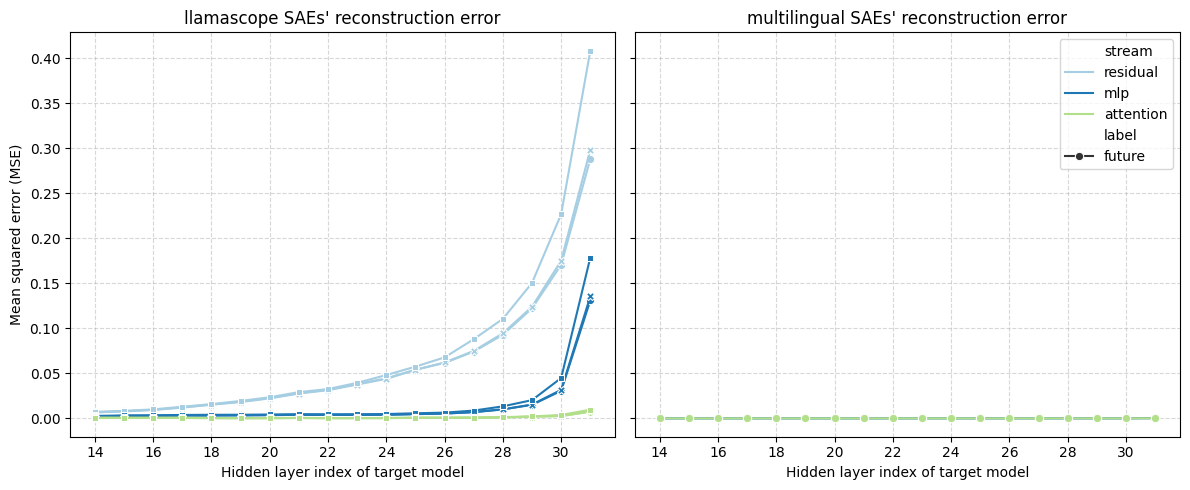

In [9]:
# Plot RMSE for each SAE side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for ax, sae in zip(axes, ['llamascope', 'translation']):
    sub = df[df['sae'] == sae]
    sns.lineplot(
        data=sub,
        x='layer',
        y='mse',
        hue='stream',
        style='label',
        palette='Paired',
        markers=True,
        dashes=False,
        legend=(sae=='translation'),
        ax=ax
    )
    sae_name = sae if sae == 'llamascope' else 'multilingual'
    ax.set_title(f"{sae_name} SAEs' reconstruction error")
    ax.set_xlabel("Hidden layer index of target model")
    ax.set_ylabel("Mean squared error (MSE)")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Move legend outside right of first plot
# axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
{'past': 0.13, 'present': 0.09, 'future': 0.14}